# Online reconstruction of pMRI data

In this notebook we study online reconstruction algorithm for pMRI data

## Introduction

Typically, MRI reconstruction is done entirely after the full acquisition of the k-space data (so-called offline reconstruction)
During the acquisition sequence of MRI can be very long, and this dead time can be used to start the reconstruction.
### Offline vs Online

In the context of pMRI the problem is stated as follows for an (calibrationless) offline reconstruction
$$
\hat{x} = \arg\min \|\Omega \mathcal{F}x - y \| + g(\Psi x) \tag{Problem 1}
$$

where: 
- $\mathcal{F}$ is the fourier transform operator 
- $\Omega$ is the sampling mask, representing the acquisition by the MRI
- $y$ is the complete observed data in kspace.
- $\Psi$ is a sparsifying transform (typically a Wavelet transform)
- $g$ is a proximable regularisation operator ($\ell_1$, groupLasso, OWL...)

Solving this problem is done by using an iterative algorithm relying on convex Optimisation and gradient descent (Condat-Vu, POGM, FISTA...) 


In an online framework Problem 1 is solved during the acquisition, and data is feeded into the iterative algorithm incrementally. Each time, a new estimate of $x$ is given by the algorithm and use as an initial guess for the next step.

$$
\hat{x}_k = \arg\min \|\Omega_k \mathcal{F}x - y_k \| + g(\Psi x) \tag{Problem 2}
$$

Now, the estimate, the observed Data and the mask all depends on the step $k$ of the acquisition.

### Timing Consideration

% TODO the batch trick and timing of MRI sequence

## Setup 

- This notebook rely on the python packages modopt, pysap, pysap-mri and their dependences.
- As a toy model, let's consider a 2D pMRI acquisition with 16 channels where the k-space ( of size 640 x 320) is sampled along 80 columns.

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as pfft

from mri.operators import FFT,WaveletN, OWL
from modopt.opt.proximity import GroupLASSO

from online.generator import KspaceGenerator, Column2DKspaceGenerator
from online.reconstructor import OnlineCalibrationlessReconstructor

from utils import implot, load_data

/home/pac/.pyenv/versions/mri/lib/python3.9/site-packages/pysap_mri-0.2.2-py3.9.egg/mri/operators/fourier/cartesian.py:34: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
/home/pac/.pyenv/versions/mri/lib/python3.9/site-packages/pysap_mri-0.2.2-py3.9.egg/mri/operators/fourier/non_cartesian.py:42: UserWarning: gpuNUFFT python package has not been found. If needed please check on how to install in README


In [2]:
DATA_DIR = "data/"
RESULT_DIR = "data/results/"
N_JOBS = 1


(16, 640, 320) complex128
(320, 320) float32
file_brain_AXFLAIR_200_6002462.h5
1


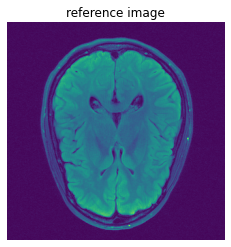

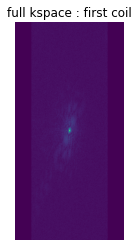

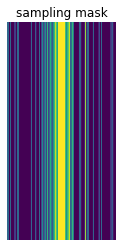

In [3]:
full_k, real_img, mask_loc, mask = load_data(DATA_DIR,1)
implot(real_img, "reference image")
implot(np.sqrt(np.abs(full_k[0])), "full kspace : first coil")
implot(mask, "sampling mask")


## Kspace Acquisition Emulation

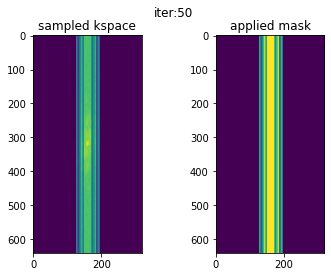

In [4]:
final_k = full_k * mask[np.newaxis, ...] # final kspace reacher after all available sampling
kspace_gen = Column2DKspaceGenerator(final_k, mask_loc,max_iter=50)
fig,axs = plt.subplots(1,2)
axs[0].set_title("sampled kspace")
axs[1].set_title("applied mask")

# warning , the animation take some time....
for iteration, (kspace, mask) in enumerate(kspace_gen):
    fig.suptitle(f"iter:{iteration}")
    axs[0].imshow(np.log(np.abs(kspace[0])+1e-10))
    axs[1].imshow(mask)
    #fig.canvas.draw()


## Operator definition
The pysap API allow us to create high level operator object, that will be combined to perforn the reconstruction.

In [5]:
kspace_gen = Column2DKspaceGenerator(final_k, mask_loc)
K_DIM = kspace_gen.shape[1:]
N_COILS = kspace_gen.shape[0]
kspace_gen[1]
# The fourier Operator apply also the sampling mask.
fourier_op = FFT(mask=kspace_gen.mask,
                 shape=K_DIM,
                 n_coils=N_COILS,
                 n_jobs=N_JOBS)

# Wavelets coefficients for each coils
linear_op = WaveletN("sym8", nb_scale=4, n_coils=16, n_jobs=N_JOBS)
# initialisation of wavelet transform
linear_op.op(np.zeros(kspace_gen.shape))

# Regularizer definition 
GL_op = GroupLASSO(weights=1e-3)
OWL_op = OWL(alpha=1e-05,
             beta=1e-12,
             bands_shape=linear_op.coeffs_shape,
             mode='band_based',
             n_coils=N_COILS,
             n_jobs=N_JOBS)

[(54, 34), (54, 34), (54, 34), (54, 34), (93, 53), (93, 53), (93, 53), (171, 91), (171, 91), (171, 91), (327, 167), (327, 167), (327, 167)]


## Metrics 

The online reconstruction process can be track with various metrics:
 - PNSR
 - SSIM
 - Relative residual, where the current estimate is compare with the current observable data
     $$ f(x_k) = \| \Omega_k \mathcal{F} x_k - y_k \| $$
 - Absolute residual, where the current estimate is compare with the final observable data.
     $$ f(x_k) = \| \Omega_f \mathcal{F} x_k - y_f \| $$
In the case of offline reconstruction relative and absolute residual are the same. Furthermore, The relative residual may have a different starting point, but will in the end converge to the same value obtain for the absolute residual.

In the case of pMRI, the calibrationless reconstruction produce an image for every coil of the system. These image are combined into a square root of sum squared (ssos).

In [6]:
from online.metrics import psnr_ssos, ssim_ssos, ssos, crop_center_square


def abs_res_ana(test,ref,mask):
    return 0.5 * np.sum(np.abs(mask[np.newaxis,...]*
                               (ref-fourier_op.op(test))))

metrics = {'psnr': {'metric': psnr_ssos,
                    'mapping': {'x_new':'test'},
                    'early_stopping': False,
                    'cst_kwargs': {'ref': real_img},
                   },
           'ssim': {'metric': psnr_ssos,
                    'mapping': {'x_new':'test'},
                    'cst_kwargs': {'ref': real_img},
                    'early_stopping': False,

                   },
           'abs_res':{'metric':abs_res_ana,
                      'mapping':{'x_new':'test'},
                      'cst_kwargs': {'mask': mask,
                                     'ref': final_k},
                      'early_stopping': False,
                     },
          }
           

## Basic Reconstruction  
### Condat Vu Algorithm

In [7]:
solver = OnlineCalibrationlessReconstructor(
        fourier_op,
        linear_op=linear_op,
        regularizer_op=GL_op,
        gradient_formulation="analysis",
        lipschitz_cst =1.1,
        verbose=30)
xf,cost, metric_results = solver.reconstruct(kspace_generator=kspace_gen,
                  optimization_alg='condatvu',
                  metrics=metrics,
                  metric_call_period=5)

Lipschitz constant is 1.1


The lipschitz constraint is satisfied


  0%|          | 0/80 [00:00<?, ?it/s]

 - mu:  0.001
 - lipschitz constant:  1.1
 - tau:  0.9523809433107515
 - sigma:  0.5
 - rho:  1.0
 - std:  None
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (640, 320)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7fb9d8942850> - 4
 - max iterations:  150
 - number of reweights:  0
 - primal variable shape:  (16, 640, 320)
 - dual variable shape:  (16, 232641)
----------------------------------------
Starting optimization...


81it [02:07,  1.58s/it]                        

 - final iteration number:  81
 - final cost value:  1000000.0
 - converged:  False
Done.
Execution time:  128.3269105290001  seconds
----------------------------------------


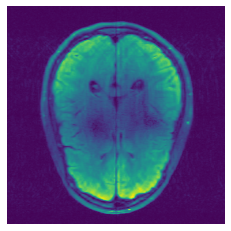

In [8]:
implot(ssos(xf))

In [11]:
metric_results


[]